In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = [224, 224]

In [3]:
train_path = '/content/drive/My Drive/Datasets/dataset/training_set'
valid_path = '/content/drive/My Drive/Datasets/dataset/test_set'

In [4]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], include_top=False) #weights='imagenet'

58892288/58889256 [==============================] - 1s 0us/step


In [5]:
#CODE 2
for layer in vgg.layers:
  layer.trainable = False

In [6]:
  # useful for getting number of classes
folders = glob('/content/drive/My Drive/Datasets/dataset/training_set/*')

In [7]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='softmax')(x)


In [8]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [9]:
# view the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 8010 images belonging to 2 classes.
Found 2010 images belonging to 2 classes.


In [12]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
251/251 [==============================] - 4331s 17s/step - loss: 0.3166 - accuracy: 0.8658 - val_loss: 0.2134 - val_accuracy: 0.9149
Epoch 2/5
251/251 [==============================] - 160s 637ms/step - loss: 0.2195 - accuracy: 0.9116 - val_loss: 0.2206 - val_accuracy: 0.9139
Epoch 3/5
251/251 [==============================] - 160s 639ms/step - loss: 0.1966 - accuracy: 0.9238 - val_loss: 0.2312 - val_accuracy: 0.9154
Epoch 4/5
251/251 [==============================] - 160s 638ms/step - loss: 0.1948 - accuracy: 0.9296 - val_loss: 0.1944 - val_accuracy: 0.9368
Epoch 5/5
251/251 [==============================] - 160s 637ms/step - loss: 0.1579 - accuracy: 0.9378 - val_loss: 0.2405 - val_accuracy: 0.9224


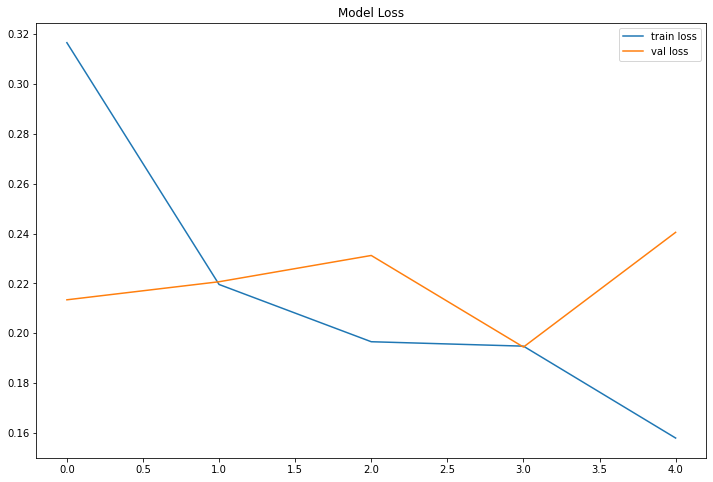

<Figure size 432x288 with 0 Axes>

In [14]:
# loss
fig = plt.figure(figsize=(12,8))
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.title('Model Loss')
plt.show()
plt.savefig('LossVal_loss')

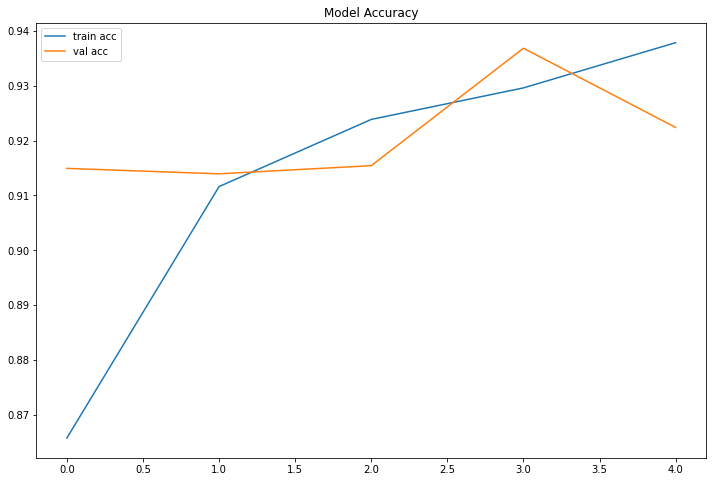

<Figure size 432x288 with 0 Axes>

In [15]:
# accuracies
fig = plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Model Accuracy')
plt.show()
plt.savefig('AccVal_acc')

In [16]:
import tensorflow as tf
from keras.models import load_model

In [161]:
model.save('dog_cat_classifier_VGG16.h5')

In [18]:
test_image = image.load_img('/content/drive/My Drive/Datasets/dataset/single_prediction/cat_or_dog_1.jpg', target_size= (224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = model.predict(test_image)

In [19]:
training_set.class_indices

{'cats': 0, 'dogs': 1}

In [20]:
if result[0][0] == 1:
    prediction = 'cat'
else:
    prediction = 'dog'
print (prediction)

dog


## WebCam



In [21]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


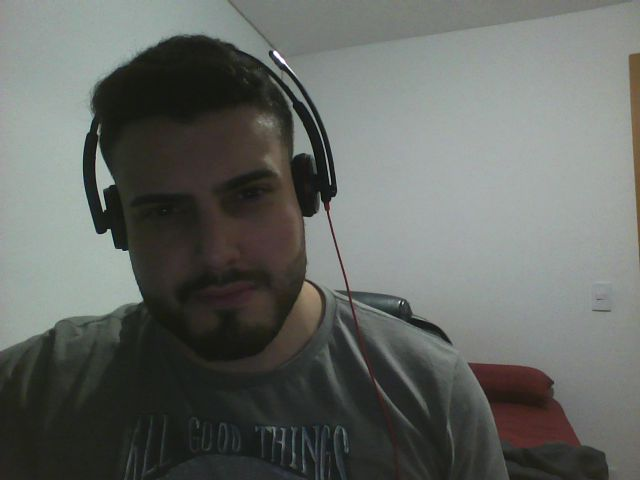

In [28]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [29]:
me = image.img_to_array((image.load_img('/content/photo.jpg', target_size= (224,224))))
me = np.expand_dims(me,axis=0)
result = model.predict(me)
if result[0][0] == 1:
    prediction = 'cat'
else:
    prediction = 'dog'
print (prediction)

dog


In [47]:
me = image.img_to_array((image.load_img('/content/photo.jpg', target_size= (224,224))))
me = np.expand_dims(me,axis=0)
result = model.predict(me)
if result[0][0] == 1:
    prediction = 'cat'
else:
    prediction = 'dog'
print (prediction)

dog


## Save Model

In [30]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image

In [31]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
  model.save_weights("model.h5")
  print("Saved model to disk")

Saved model to disk


In [32]:
model2 = model_from_json(open("model.json", "r").read())
model2.load_weights('model.h5')

## Load Model

In [33]:
from keras.models import load_model
import tensorflow as tf
from keras.preprocessing import image

In [34]:
model = load_model('/content/dog_cat_classifier_VGG16.h5')

## Flask

In [35]:
from flask import Flask
from flask import render_template
from flask import request
import os

In [36]:
app = Flask(__name__)
UPLOADER_FOLDER = '/content/'

@app.route("/",methods =["GET","POST"])
def upload_predict():
  if request.method == "POST":
    image_file = request.files[image]
    if image_file:
      image_location = os.path.join(
          UPLOADER_FOLDER,
          image_file.filename
      )
      image_file.save(image_location)
      pred = predict(image_location)
      print(pred)
      return render_template("index.html", prediction = pred, image_loc = image_location)
  return render_template("index.html", prediction = 0, image_loc=None)

In [38]:
def predict(img_path):
  model = load_model('/content/VGG16_DOG_CAT/dog_cat_classifier_VGG16.h5')
  img = image.img_to_array((image.load_img(img_path, target_size= (224,224))))
  img = np.expand_dims(img,axis=0)
  result = model.predict(img)
  if result[0][0] == 1:
    prediction = 'cat'
  else:
    prediction = 'dog'
  return prediction

In [40]:
if __name__ == "__main__":
  model = load_model('/content/dog_cat_classifier_VGG16.h5')
  app.run(port=5000, debug=True)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with stat


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Imagenet

In [41]:
from keras.applications.vgg16 import VGG16

In [42]:
vgg16_model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 5s 0us/step


In [158]:
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import matplotlib.pyplot as plt 
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import os 

img1 = "/content/drive/My Drive/Datasets/dataset/single_prediction/cat_or_dog_1.jpg"
img2 = "/content/drive/My Drive/Datasets/dataset/single_prediction/cat_or_dog_2.jpg"
img3 = "/content/Gatinha.jpeg"
img4 = "/content/Lambo.jpg"
imgs = [img1, img2, img3, img4]

In [159]:
class pred:
  def __init__(self, modelo):
    self.modelo = modelo
  def load_img(self,path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img 
  def predict_(self):
    f, ax = plt.subplots(1, 4)
    f.set_size_inches(80, 40)
    for i in range(4):
        ax[i].imshow(Image.open(imgs[i]).resize((200, 200), Image.ANTIALIAS))
    plt.show()
    
    f, axes = plt.subplots(1, 4)
    f.set_size_inches(80, 20)
    for i,img_path in enumerate(imgs):
        img = _load_image(img_path)
        preds  = decode_predictions(self.modelo.predict(img), top=3)[0]
        b = sns.barplot(y=[c[1] for c in preds], x=[c[2] for c in preds], color="gray", ax=axes[i])
        b.tick_params(labelsize=55)
        f.tight_layout()
  pass

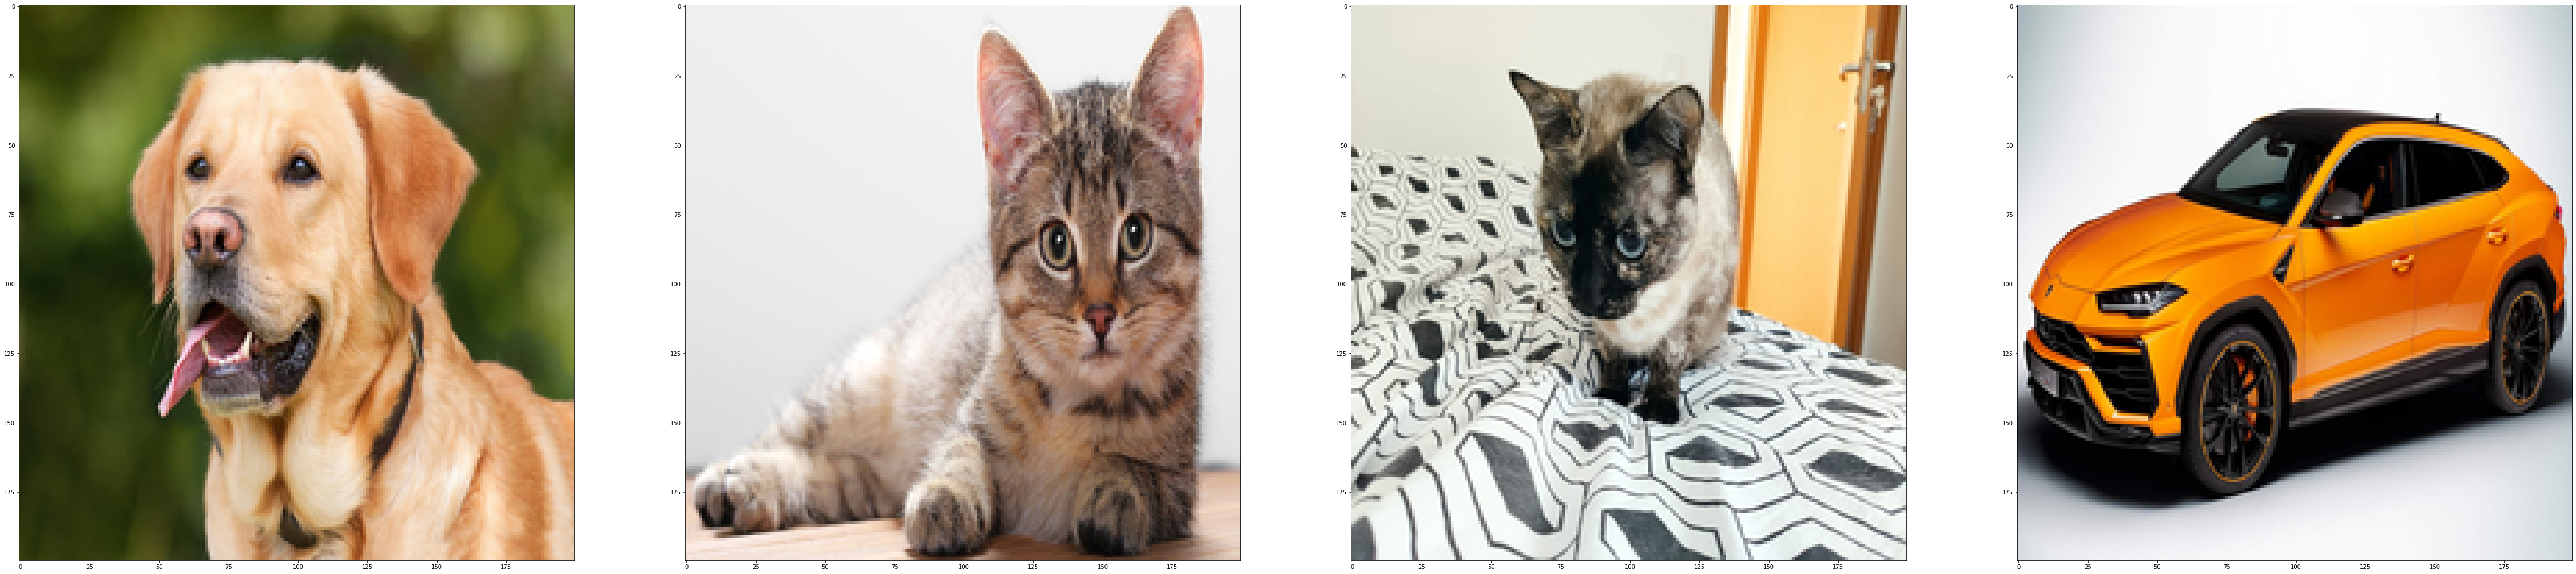

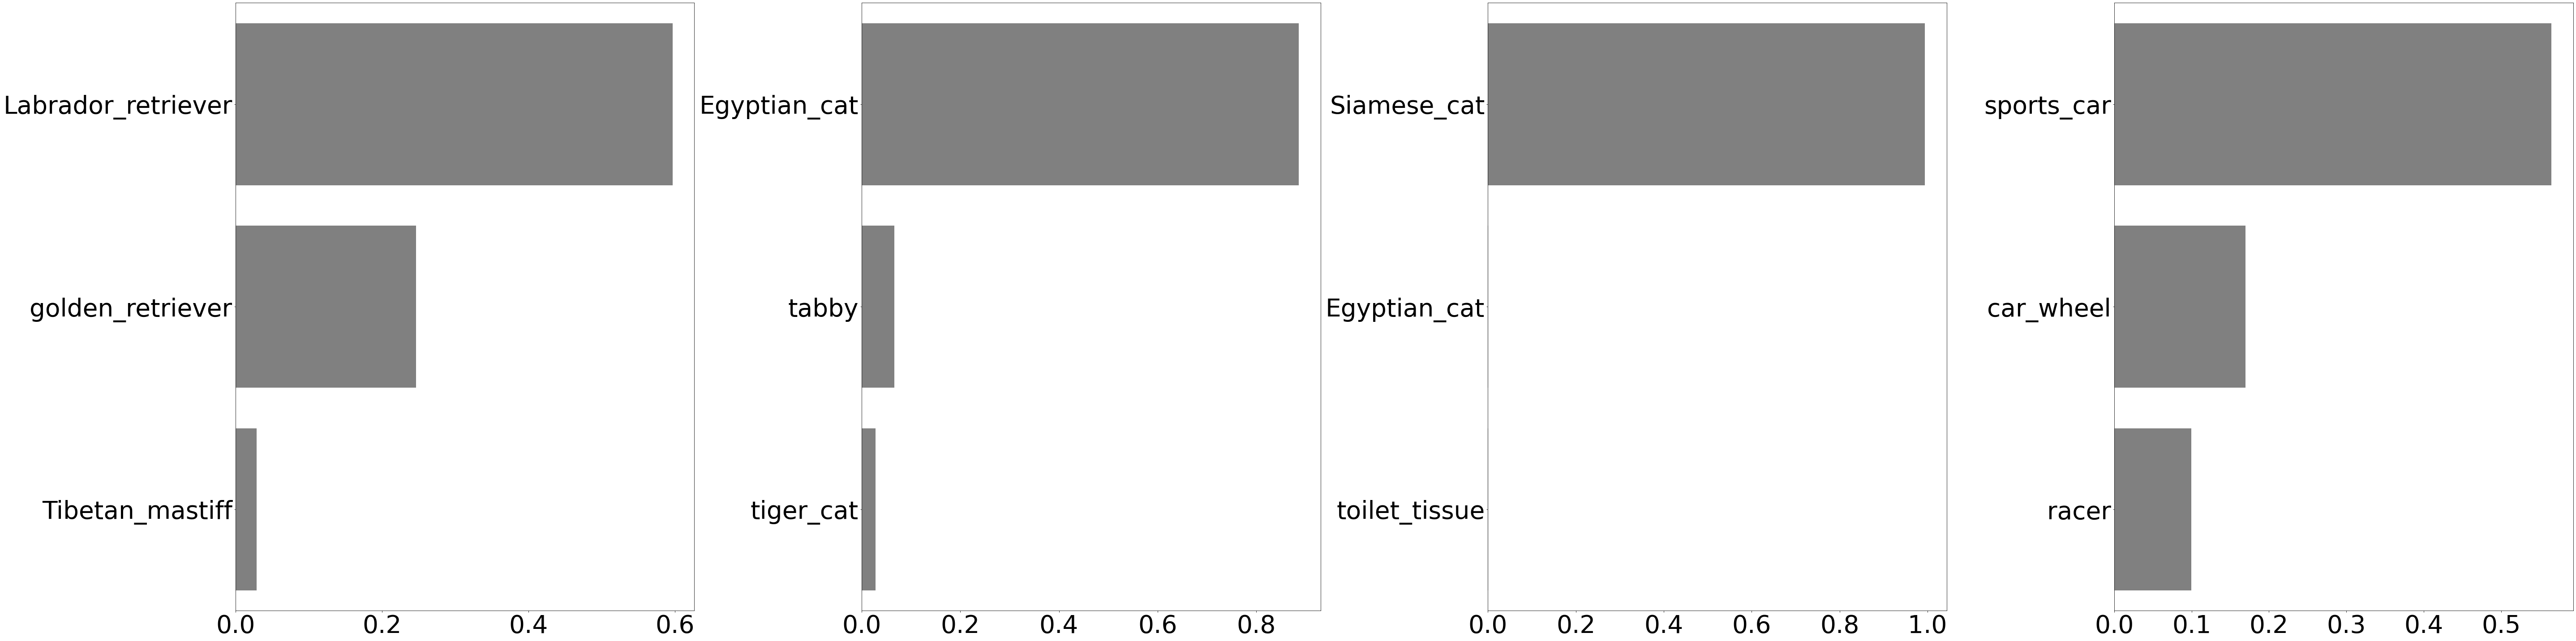

In [160]:
pred(vgg16_model).predict_()